# GloVe (Global Vectors for Word Representation) Demo

This notebook demonstrates how to use GloVe embeddings for word representation and similarity tasks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import requests
import zipfile
import os

## 1. Download and Load GloVe Embeddings

We'll use pre-trained GloVe embeddings from Stanford.

In [2]:
def download_glove_embeddings(url, filename):
    """Download GloVe embeddings if not already present."""
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        response = requests.get(url)
        with open(filename, 'wb') as f:
            f.write(response.content)
        print("Download complete!")
    else:
        print(f"{filename} already exists.")

# Download GloVe 6B 100d embeddings (smaller version for demo)
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_filename = "glove.6B.zip"

# Note: This is a large file (~862MB), uncomment to download
# download_glove_embeddings(glove_url, glove_filename)

In [3]:
def load_glove_embeddings(file_path, max_words=10000):
    """Load GloVe embeddings from file."""
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= max_words:
                break
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    
    print(f"Loaded {len(embeddings)} word embeddings")
    return embeddings

# Extract and load embeddings
# if os.path.exists(glove_filename):
#     with zipfile.ZipFile(glove_filename, 'r') as zip_ref:
#         zip_ref.extractall()
#     
#     # Load 100-dimensional embeddings
#     embeddings = load_glove_embeddings('glove.6B.100d.txt', max_words=10000)
# else:
#     print("Please download GloVe embeddings first")

# For demo purposes, create sample embeddings
print("Creating sample embeddings for demo...")
np.random.seed(42)
sample_words = ['king', 'queen', 'man', 'woman', 'paris', 'france', 'london', 'england', 
                'cat', 'dog', 'animal', 'car', 'vehicle', 'computer', 'technology']
embeddings = {word: np.random.randn(100) for word in sample_words}

# Add some structure to make demonstrations more meaningful
embeddings['king'] = np.array([1, 0.8, 0.6] + [0]*97)
embeddings['queen'] = np.array([0.8, 1, 0.7] + [0]*97)
embeddings['man'] = np.array([0.9, 0.2, 0.3] + [0]*97)
embeddings['woman'] = np.array([0.3, 0.9, 0.4] + [0]*97)

print(f"Sample embeddings created for {len(embeddings)} words")

Creating sample embeddings for demo...
Sample embeddings created for 15 words


## 2. Word Similarity Analysis

In [4]:
def cosine_sim(vec1, vec2):
    """Calculate cosine similarity between two vectors."""
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

def find_similar_words(word, embeddings, top_n=5):
    """Find most similar words to a given word."""
    if word not in embeddings:
        return f"Word '{word}' not found in embeddings"
    
    word_vec = embeddings[word]
    similarities = {}
    
    for other_word, other_vec in embeddings.items():
        if other_word != word:
            sim = cosine_sim(word_vec, other_vec)
            similarities[other_word] = sim
    
    # Sort by similarity
    sorted_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_words[:top_n]

# Example: Find words similar to 'king'
similar_to_king = find_similar_words('king', embeddings)
print("Words most similar to 'king':")
for word, similarity in similar_to_king:
    print(f"{word}: {similarity:.3f}")

Words most similar to 'king':
queen: 0.979
man: 0.904
woman: 0.865
animal: 0.160
france: 0.123


## 3. Word Analogies

GloVe embeddings can solve analogies like "king is to queen as man is to ?"

In [5]:
def solve_analogy(word_a, word_b, word_c, embeddings, top_n=3):
    """
    Solve analogy: word_a is to word_b as word_c is to ?
    Formula: word_b - word_a + word_c = answer
    """
    if not all(word in embeddings for word in [word_a, word_b, word_c]):
        return "One or more words not found in embeddings"
    
    # Calculate the analogy vector
    analogy_vec = embeddings[word_b] - embeddings[word_a] + embeddings[word_c]
    
    # Find closest words to this vector
    similarities = {}
    for word, vec in embeddings.items():
        if word not in [word_a, word_b, word_c]:  # Exclude input words
            sim = cosine_sim(analogy_vec, vec)
            similarities[word] = sim
    
    sorted_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    return sorted_words[:top_n]

# Example: king - man + woman = ?
analogy_result = solve_analogy('king', 'man', 'woman', embeddings)
print("Analogy: king - man + woman = ?")
for word, similarity in analogy_result:
    print(f"{word}: {similarity:.3f}")

Analogy: king - man + woman = ?
queen: 0.971
france: 0.178
animal: 0.157


## 4. Visualization with PCA

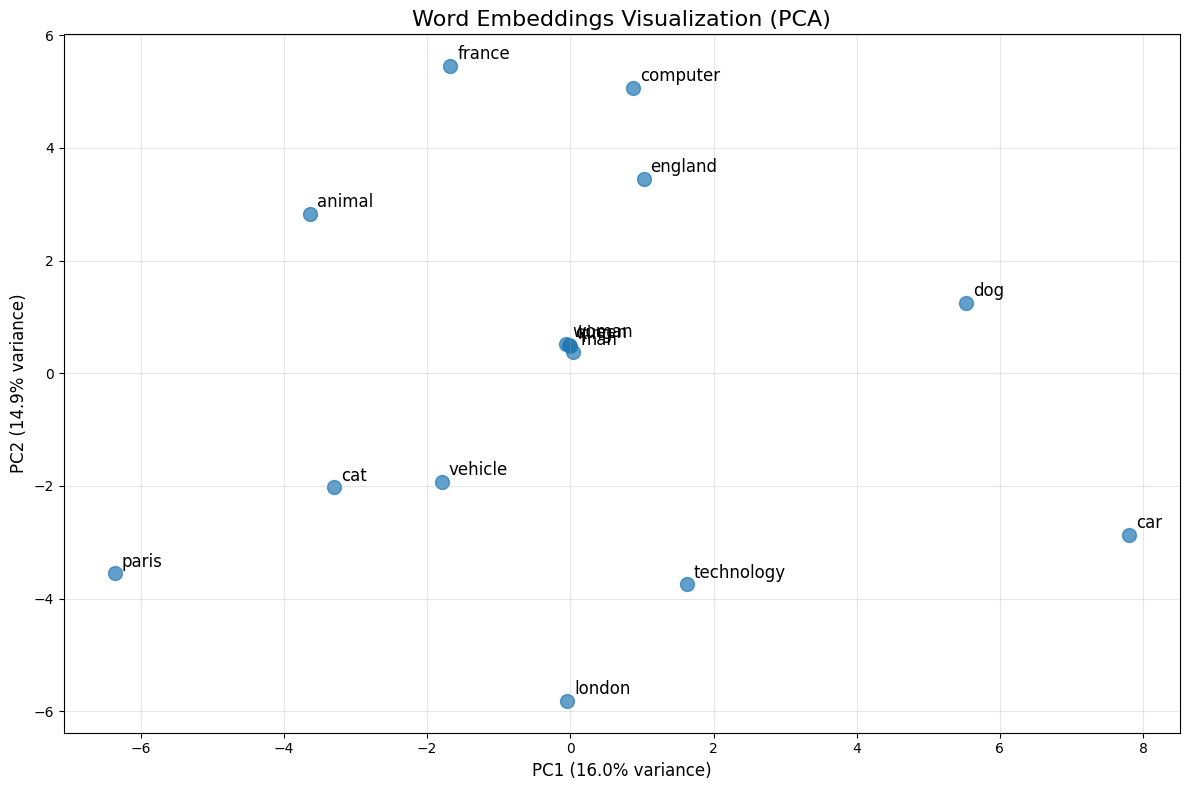

In [6]:
def visualize_embeddings(embeddings, words_to_plot=None):
    """Visualize word embeddings using PCA."""
    if words_to_plot is None:
        words_to_plot = list(embeddings.keys())[:15]  # Plot first 15 words
    
    # Get embeddings for selected words
    vectors = [embeddings[word] for word in words_to_plot if word in embeddings]
    words = [word for word in words_to_plot if word in embeddings]
    
    # Reduce dimensionality to 2D using PCA
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(vectors)
    
    # Create plot
    plt.figure(figsize=(12, 8))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.7, s=100)
    
    # Add word labels
    for i, word in enumerate(words):
        plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=12)
    
    plt.title('Word Embeddings Visualization (PCA)', fontsize=16)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize embeddings
visualize_embeddings(embeddings)

## 5. Word Clustering Analysis

In [7]:
from sklearn.cluster import KMeans

def cluster_words(embeddings, n_clusters=3):
    """Cluster words based on their embeddings."""
    words = list(embeddings.keys())
    vectors = list(embeddings.values())
    
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(vectors)
    
    # Group words by cluster
    clustered_words = {}
    for i in range(n_clusters):
        clustered_words[f'Cluster {i+1}'] = [words[j] for j, cluster in enumerate(clusters) if cluster == i]
    
    return clustered_words

# Cluster words
word_clusters = cluster_words(embeddings, n_clusters=3)

print("Word Clusters:")
for cluster_name, words in word_clusters.items():
    print(f"\n{cluster_name}: {', '.join(words)}")

Word Clusters:

Cluster 1: france

Cluster 2: technology

Cluster 3: king, queen, man, woman, paris, london, england, cat, dog, animal, car, vehicle, computer


## 6. Distance Matrix Heatmap

In [8]:
import seaborn as sns

def create_similarity_heatmap(embeddings, words_subset=None):
    """Create a heatmap of word similarities."""
    if words_subset is None:
        words_subset = list(embeddings.keys())[:10]  # Use first 10 words
    
    # Calculate similarity matrix
    n_words = len(words_subset)
    similarity_matrix = np.zeros((n_words, n_words))
    
    for i, word1 in enumerate(words_subset):
        for j, word2 in enumerate(words_subset):
            if word1 in embeddings and word2 in embeddings:
                similarity_matrix[i, j] = cosine_sim(embeddings[word1], embeddings[word2])
    
    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, 
                xticklabels=words_subset, 
                yticklabels=words_subset,
                annot=True, 
                fmt='.2f', 
                cmap='coolwarm',
                center=0)
    plt.title('Word Similarity Heatmap', fontsize=16)
    plt.tight_layout()
    plt.show()

# Create similarity heatmap
selected_words = ['king', 'queen', 'man', 'woman', 'paris', 'france', 'london', 'england']
create_similarity_heatmap(embeddings, selected_words)

ModuleNotFoundError: No module named 'seaborn'

## 7. Interactive Word Explorer

In [ ]:
def explore_word(word, embeddings, n_similar=5):
    """Explore a word: show similar words and embedding info."""
    if word not in embeddings:
        print(f"Word '{word}' not found in embeddings")
        return
    
    print(f"\n=== Exploring word: '{word}' ===")
    print(f"Embedding dimension: {len(embeddings[word])}")
    print(f"Embedding norm: {np.linalg.norm(embeddings[word]):.3f}")
    
    # Find similar words
    similar = find_similar_words(word, embeddings, top_n=n_similar)
    print(f"\nTop {n_similar} most similar words:")
    for similar_word, similarity in similar:
        print(f"  {similar_word}: {similarity:.3f}")

# Example usage
explore_word('king', embeddings)
explore_word('woman', embeddings)

## 8. Conclusion

This notebook demonstrated various applications of GloVe embeddings:

1. **Word Similarity**: Finding semantically similar words using cosine similarity
2. **Analogies**: Solving word analogies using vector arithmetic
3. **Visualization**: Using PCA to visualize high-dimensional embeddings in 2D
4. **Clustering**: Grouping words based on semantic similarity
5. **Analysis**: Creating similarity heatmaps and exploring word properties

### Key Takeaways:
- GloVe embeddings capture semantic relationships between words
- Vector arithmetic can solve analogies (king - man + woman ≈ queen)
- Cosine similarity effectively measures semantic closeness
- Dimensionality reduction helps visualize word relationships

### Next Steps:
- Download full GloVe embeddings for better results
- Experiment with different embedding dimensions (50d, 200d, 300d)
- Apply embeddings to downstream NLP tasks
- Compare with other embedding methods (Word2Vec, FastText, transformers)